Testing `mushi` with `msprime` simulations
==

In [1]:
%matplotlib notebook
import mushi
import msprime
%cd stdpopsim
from stdpopsim import homo_sapiens
%cd ../
from IPython.display import display, SVG
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time

/Users/williamdewitt/Desktop/repos/dement/stdpopsim
/Users/williamdewitt/Desktop/repos/dement


## `msprime` simulation
### Download human recombination maps

In [2]:
print(homo_sapiens.genome.default_genetic_map)
gmap = homo_sapiens.HapmapII_GRCh37()
gmap.download()

HapmapII_GRCh37


### Define true demographic history $\eta(t)$ based on the Tennessen et al. `TwoPopOutOfAfrica` model in `stdpopsim`, mutation rate history $\mu(t)$, and other simulation parameters
simulate a tree sequence, print number of linkage blocks, and plot the first tree in the sequence

766489 trees (here's the first)


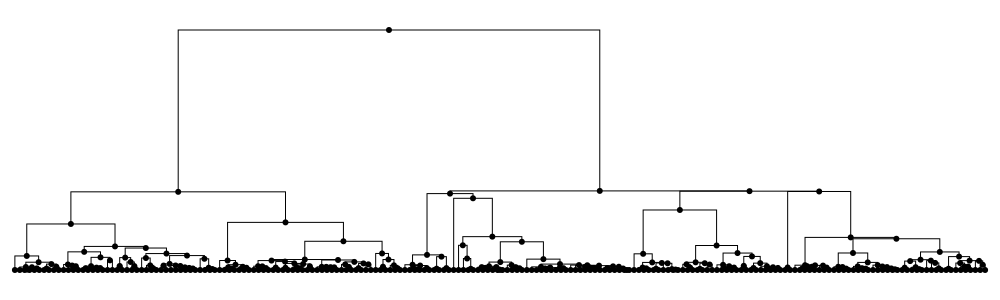

In [3]:
chrom = homo_sapiens.genome.chromosomes["chr1"]
# model = homo_sapiens.TennessenTwoPopOutOfAfrica()
model = homo_sapiens.TennessenOnePopAfrica()
n = 200
population_idx = 0 # 0 for AFR, 1 for EUR
samples = [msprime.Sample(population=population_idx, time=0) for j in range(n)]
seed = time.time()
tree_sequence = msprime.simulate(random_seed=seed,
                                 samples=samples,
                                 recombination_map=chrom.recombination_map(),
                                 **model.asdict())
print(f"{len(tree_sequence.breakpoints(as_array=True))} trees (here's the first)")
display(SVG(tree_sequence.first().draw(format='svg', width=1000, height=300, node_labels={},
                                       mutation_labels={})))#, max_tree_height='ts')))

<IPython.core.display.Javascript object>


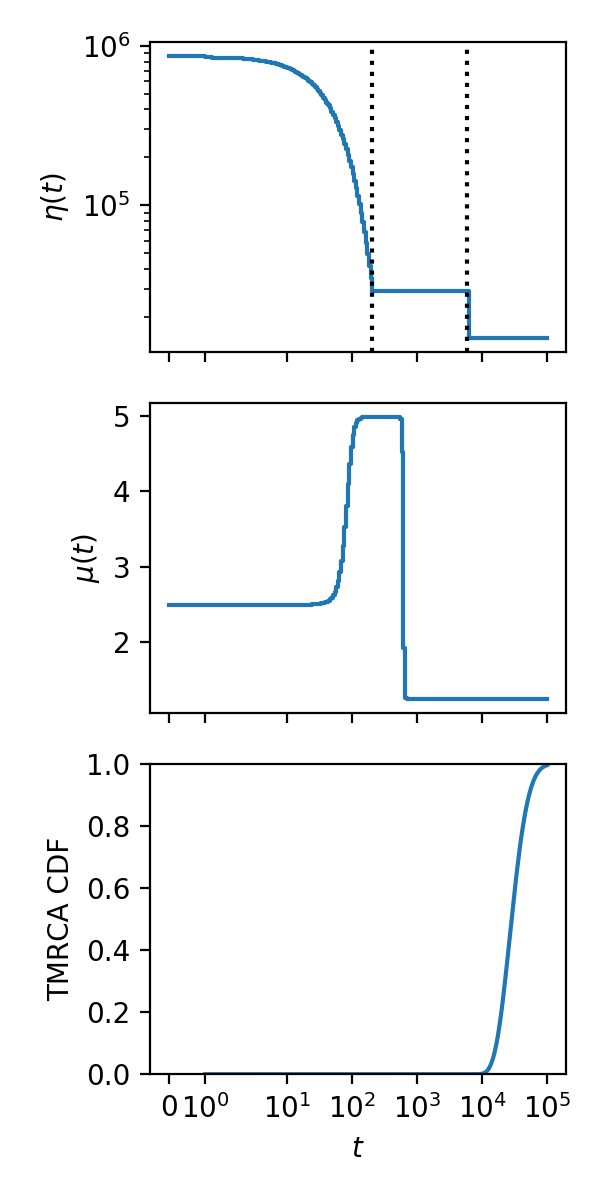

In [4]:
# time grid
t = np.logspace(0, 5, 200)
# t = np.linspace(1, 3e4, 500)

# η(t)
dd = msprime.DemographyDebugger(Ne=model.default_population_size,
                                population_configurations=model.population_configurations,
                                demographic_events=model.demographic_events,
                                migration_matrix=model.migration_matrix)
# note: the factor of 2 accounts for diploidy
y = 2 * dd.population_size_trajectory(np.concatenate(([0], t)))[:, population_idx]
η = mushi.PiecewiseConstantHistory(t, y)

# μ(t)
z = np.ones(len(t) + 1)
z[1:] += expit(.1 * (t - 80)) - 1.5 * expit(.1 * (t - 600))
# z[1:] += expit(1 * (t - 10)) - 1.5 * expit(1 * (t - 100))
μ = mushi.PiecewiseConstantHistory(t, chrom.length * chrom.default_mutation_rate * z)

history = mushi.JointHistory(η, μ)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(3, 6))

plt.sca(axes[0])
η.plot()
plt.ylabel('$η(t)$')
for t in dd.epoch_times[1:]:
    plt.axvline(t, c='k', ls=':')
plt.yscale('log')

plt.sca(axes[1])
μ.plot()
plt.ylabel('$μ(t)$')

plt.sca(axes[2])
plt.plot(η.change_points, mushi.SFS(n).tmrca_cdf(history.η))
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])

plt.xlabel('$t$')
plt.xscale('symlog')
plt.tight_layout()
plt.show()

### place mutations on simulated tree sequence according to $\mu(t)$
We iterate over the epochs in our dense time grid

In [5]:
for start_time, end_time, mutation_rate in μ.epochs():
    print(f'epoch boundaries: ({start_time:.2f}, {end_time:.2f}), μ: {mutation_rate:.2f}', flush=True, end='     \r')
    # note: the factor of 1 / chrom.length is needed to scale the mutation rate from sites to genomes
    tree_sequence = msprime.mutate(tree_sequence,
                                   rate=mutation_rate / chrom.length,                                   
                                   start_time=start_time,
                                   end_time=end_time,
                                   random_seed=seed,
                                   keep=True)

### compute and plot the SFS

<IPython.core.display.Javascript object>


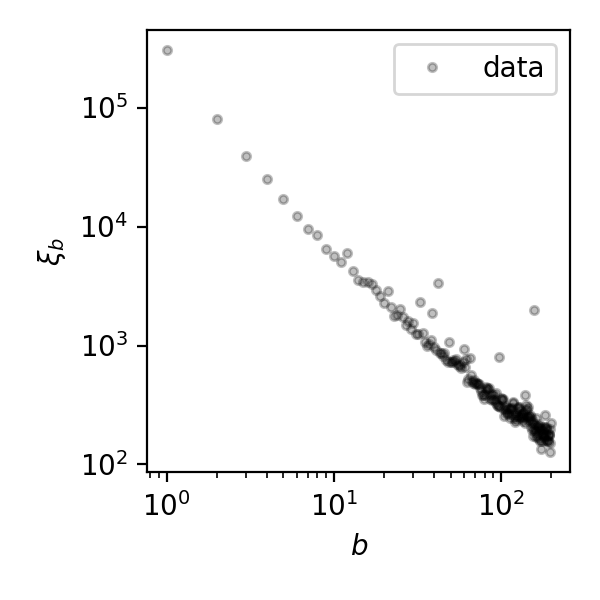

In [6]:
x = tree_sequence.allele_frequency_spectrum(polarised=True, span_normalise=False)[1:-1]
sfs = mushi.SFS(n=None, x=x)

plt.figure(figsize=(3, 3))
sfs.plot()
plt.tight_layout()
plt.show()

## Inferring $\mu(t)$ with `mushi`

### Invert the `TCC>TTC` SFS conditioned on $\eta(t)$ to get $\mu(t)$

<IPython.core.display.Javascript object>


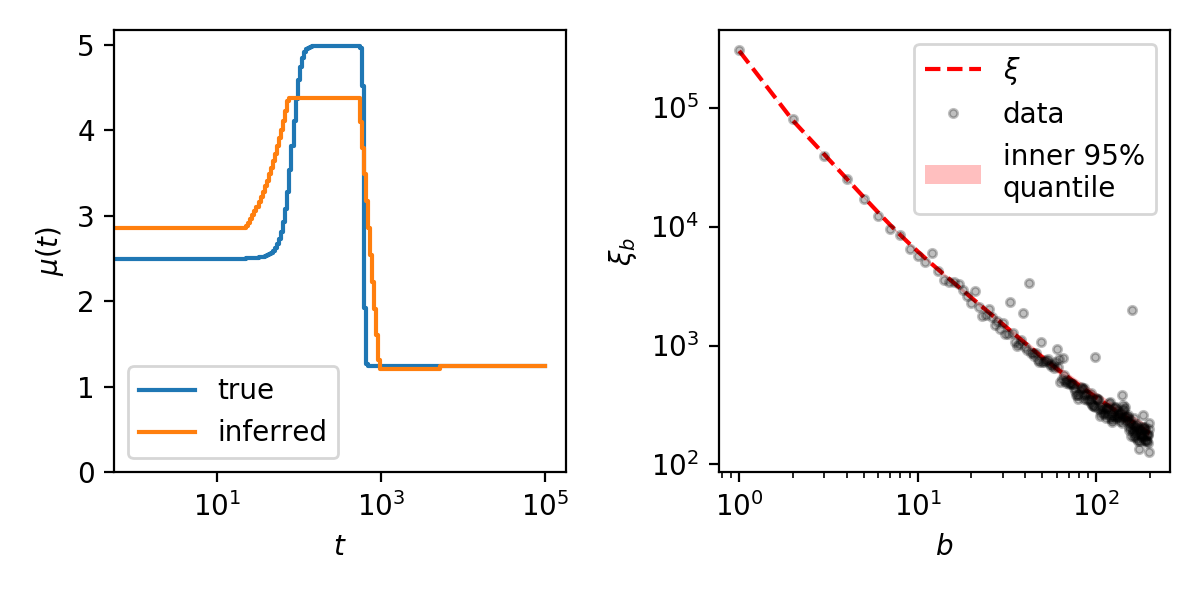

In [19]:
λ = 5e-4
α = .99
s = 1e-6
steps = 50000
μ_inferred = sfs.infer_μ(η, λ=λ, α=α, s=s, steps=steps,
                         fit='prf')

history_inferred = mushi.JointHistory(η, μ_inferred)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
history.μ.plot(label='true')
history_inferred.μ.plot(label='inferred')
plt.xlabel('$t$')
plt.ylabel('$μ(t)$')
plt.xscale('log')
plt.ylim((0, None))

plt.subplot(1, 2, 2)
sfs.plot(history_inferred,
         prf_quantiles=True
        )
plt.tight_layout()
plt.show()

### compare likelihood of true Vs inferred history

In [20]:
sfs.ℓ(history), sfs.ℓ(history_inferred)

(-6826.165217135525, -6970.135787816856)